# Datasets/DataLoader
데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 잇음  
-> 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적임  
PyTorch는 `torch.utils.data.DataLoader`와 `torch.utils.data.Dataset`의 두 가지 데이터 기본 요소를 제공하여 미리 준비된(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 함  
- `Dataset`은 샘플과 정답(label)을 저장
- `DataLoader`는 `Dataset`을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감쌈

## 데이터셋 불러오기


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data", # 저장 경로
    train = True, # 학습용 또는 테스트용 데이터셋 여부 지정
    download = True, # 데이터가 없는 경우 다운로드 할지
    transform=ToTensor() # 특징과 정답 변형 여부 지정
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [2]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## 데이터셋을 순회하고 시각화하기
리스트(list)처럼 직접 접근할 수 있음

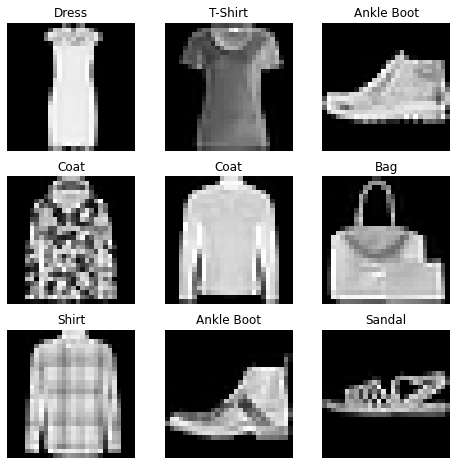

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for idx in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1, )).item()
    img, label = training_data[sample_idx]
    fig.add_subplot(rows, cols, idx)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기
사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 함  
1. `__init__`
2. `__len__`
3. `__getitem__`

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDatasets(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=["file_name", "label"])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### `__init__`
`Dataset` 객체가 생성(instantiate) 될 때 한 번만 실행  
이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 변형을 초기화

#### `__len__`
데이터셋의 샘플 개수를 반환

#### `__getitem__`
주어진 인덱스에 해당하는 샘플을 데이터셋에서 불러오고 반환  
- 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고, 
- `read_image`를 사용하여 이미지를 텐서로 변환하고, 
- `self.img_labels`의 csv 데이터로부터 해당하는 정답(labels)을 가져오고,
- (해당하는 경우) 변형 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python dict 형태로 반환

## DataLoader로 학습용 데이터 준비하기
`Dataset`은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 진행  
모델을 학습할 때, 일반적으로 샘플들을 `미니배치(minibatch)`로 전달하고, 매 에폭(epoch)마다 데이터를 다시 석어서 과적합을 막고, Python의 `multiprocessing`을 사용하여 데이터 검색 속도를 높이려고 함

`DataLoader`는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 순회하기(iterate)
`DataLoader`에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate) 할 수 있음   

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


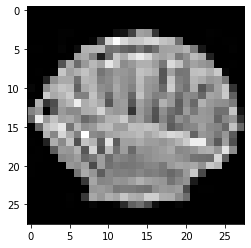

Label: 8


In [6]:
# 이미지와 정답을 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 단일 및 다중 프로세스 데이터 로딩
`DataLoader`는 기본적으로 단일 프로세스 데이터 로드를 사용  
Python 프로세스 내에서 GIL(Global Interpreter Lock)은 스레드 간에 Python 코드를 완전히 병렬화하는 것을 방지  
-> `num_workers`를 양의 정수로 설정해 다중 프로세스 데이터 로드를 수행할 수 있게 변경 가능

### 단일 프로세스 데이터 로드(기본값)
`DataLoader`에서 데이터 가져오기는 초기화되는 것과 동일한 프로세스에서 수행  
-> 데이터 로드가 연산을 차단할 수 있음  
-> 데이터 세트가 작고 메모리에 완전히 로드될 수 있는 경우 선호되는 방식  
-> 종종 읽기 쉬운 오류 추적을 보여주므로 디버깅에 유용

### 다중 프로세스 데이터 로링
`DataLoader`의 반복자가 생성될 때마다 프로세스가 생성

## 메모리 고정
데이터 로드의 경우 에 전달 `pin_memory=True`하면, 가져온 데이터 Tensor가 고정된 메모리에 자동으로 저장되므로 CUDA 지원 GPU로 더 빠르게 데이터를 전송할 수 있음  

In [7]:
class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.inp = torch.stack(transposed_data[0], 0)
        self.tgt = torch.stack(transposed_data[1], 0)

    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

def collate_wrapper(batch):
    return SimpleCustomBatch(batch)

inps = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
tgts = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
dataset = TensorDataset(inps, tgts)

loader = DataLoader(dataset, batch_size=2, collate_fn=collate_wrapper,
                    pin_memory=True)

for batch_ndx, sample in enumerate(loader):
    print(sample.inp.is_pinned())
    print(sample.tgt.is_pinned())

False
False
False
False
False
False
False
False
False
False


## 스터디
DataSet ->   
DataLoader -> mini-batch